# <b>Importance Estimation for Neural Network Pruning</b>
---
<b>Author</b> : V.Naveen Chander <br>
<b>Objective</b>    : Optimizing Convolutional Neural networks <br>
<b>Introduction</b> : This Notebook Demonstarates a framework for Optimizing MultiLayer Perceptron Neural Network. <br> 
<b>Keypoints</b>    : Importance Estimation, Iterative Training and Pruning <br>
<b>Built using</b> : Tensorflow, Keras <br>
<b>Run Time</b>     : 5 minutes 
 

# MLP Architecture
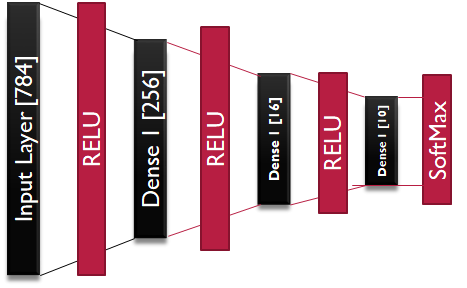
Layer 1: <b>Dense 784x 256 </b> <br>
Layer 2: <b>Dense 256x 16 </b> <br> 
Layer 3: <b>Dense 16x 10 with SoftMax</b> <br> 
Total NUmber of Model parameters : <b>209,514</b>

<b>1. Import Dependencies</b>

In [1]:
import tensorflow as tf
import math
from keras import layers
from keras import models
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from kerassurgeon import identify
from kerassurgeon.operations import delete_channels,delete_layer
from keras.datasets import mnist
from keras.utils import to_categorical

def build_model(num):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(28, 28,1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(num, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.summary()
    return model

C:\Users\mghnv\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mghnv\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mghnv\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mghnv\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

<b>2. Train on MNIST Dataset

In [2]:
# Prepare the Dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images  = test_images.reshape((10000, 28, 28, 1))
# Normallize
train_images = train_images.astype('float32')/255
test_images  = test_images.astype('float32')/255

# Convert from Numbers (0 ->9) to Binary Classes
train_labels = to_categorical(train_labels)
test_labels  = to_categorical(test_labels)
# Build and Compile model
model = build_model(256)
orig_model = model  # Copy of the original model
# Train the digit classification model
#opt = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
# Train Model
model.fit(train_images, train_labels,batch_size=100, epochs=5, validation_split=0.1)
# Evaluate MOdel
test_loss, test_acc = model.evaluate(test_images, test_labels)
#
print('first test accuracy:', test_acc)


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 209,514
Trainable params: 209,514
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 4s 67us/step - loss: 0.2959 - acc: 0.9163 - val_loss: 0.1161 - val_acc: 0.9693
Epoch 2/5
54000/54000 [==============================] - 3s 53us/step - loss: 0.1185 - acc: 0.9654 - val_loss: 0.0946 - val_acc: 0.9742
Epoch 3/5
54000/54000 [==============================] - 3s 52us/step - loss: 0.0771 - acc: 0.9766 - val_loss: 0.0821 - val_acc: 0.9758
Epoch 4/5
54000/54000 [==============================] - 3s 51us/step - loss: 0.0556 - acc: 0.9828 - val_loss: 0.0763 - val_acc: 0.9780
Epoch 5/5
10000/10000 [==============================] - 0s 29us/step
first test accuracy: 0.974


<b>3. Define Importance Function</b>

In [3]:
# Gradient Computation
def compute_gradient(model):
    images = tf.convert_to_tensor(train_images, dtype=tf.float32)
    train_labels_tf = tf.convert_to_tensor(train_labels, dtype=tf.int64)
    logits = model(images)
    loss_value = tf.keras.backend.categorical_crossentropy(train_labels_tf,logits,from_logits=True)
    #tf.enable_eager_execution()
    grads = tf.gradients(loss_value, model.trainable_weights,unconnected_gradients='zero')
    # Initialisation operation
    init = tf.global_variables_initializer()
    # Creating a session and running the graph
    with tf.Session() as sess:
        sess.run(init)
        dW_np = sess.run(grads)
    return (dW_np)

<b>4. Compute Importance for all Weights</b><br>
---
<font color=blue><b>Implements Importance Pruning Algorithm based on paper titled,
"Importance Estimation for Neural Netowrk Pruning", [Molchanov et.al 2019] </b><br></font>

<b>Importance of each model parameter is calculated by </br>
    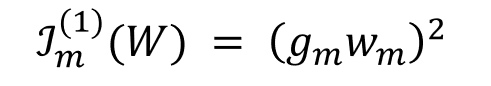

where, Im = Importance of mth model parameter <br>
gm = gradient of a model parameter w.r.t to Cost Function(Train Error)<br>
wm = Weight 

In [4]:
# Compute Importance Values
grad = compute_gradient(model)
weights = model.get_weights()
importance = []
for i in range(len(grad)):
    imp = np.multiply(grad[i],weights[i])
    imp = np.multiply(imp,imp)
    importance.append(imp)

In [64]:
max_val = (importance[0]).max()
importance[0].shape
imp_val_arr = importance[0].flatten()
imp_val_list = imp_val_arr.tolist()
len([x for x in imp_val_list if x > 0.005*max_val])

11899

<b>5. Plot the Importance Values of all Model Parameters

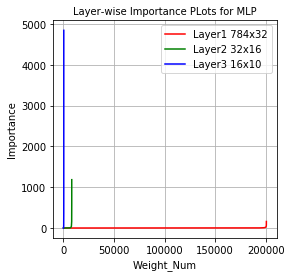

In [6]:
plt.figure(figsize=(4,4))
for i in range(len(importance)):
    if(i%2==0):
        x = importance[i]
        x=x.reshape(1,-1)
        x.sort()
        if(int((i+2)/2)==1):
            plt.plot(x.T,color='r',label="Layer1 784x32")
        elif(int((i+2)/2)==2):
            plt.plot(x.T,color='g',label='Layer2 32x16')
        elif(int((i+2)/2)==3):
            plt.plot(x.T,color='b',label='Layer3 16x10')
plt.title("Layer-wise Importance PLots for MLP",fontsize=10) 
plt.xlabel('Weight_Num')
plt.ylabel('Importance')    
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

<b>Plot Layer-wise Importance Values in Seperate plots</b>

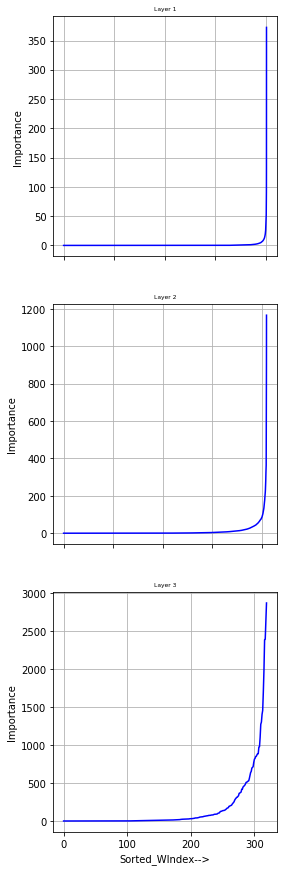

In [65]:
# plot Layer-wise Importance Values
fig, axs = plt.subplots(3,figsize=(4,15))
for i in range(len(importance)):
    if(i%2==0):
        x = importance[i]
        x=x.reshape(1,-1)
        x.sort()
        #plt.style.use('dark_background')   
        #axs.figure(figsize=(4,4))
        axs[int(i/2)].set_title(("Layer "+str(int(i/2+1))),fontsize=6)
        axs[int(i/2)].plot(x.T,color='b')
        axs[int(i/2)].set(xlabel='Sorted_WIndex-->',ylabel='Importance')
        axs[int(i/2)].grid(True)
for ax in axs.flat:
    ax.label_outer()

<b>OBSERVATIONS</b><br>
1.	Importance values decrease from last layer to first layer. The relatively low importance of the first hidden layer neurons and weights when compared to those in the last layer allow us to prune a larger percentage of weights from the first hidden layer.
2.	In the fits hidden layer, most of the weights have relative importance close to zero and a clear set of weights have high importance values.


<b>PRUNING CRITERIA</b><br>
•	Retain parameters that have Importance Value >= 0.5% of the maximum Importance Value. <br>
•	Here, 0.5% is the Hyper-parameter. <br>
•	Second and Third layers shall not be pruned.<br>


---
## <b> Prune and Train Iteratively</b>
---

In [30]:
num_iter =3
orig_neur = 256
prune_percentage=((np.linspace(5,95,19))).tolist()
test_acc_arr = np.zeros(len(prune_percentage))
##------------------------------------------------------------------------------
neurons_after_pruning = [int(orig_neur*(1- (x/100))) for x in prune_percentage]
##------------------------------------------------------------------------------
for i in range(len(neurons_after_pruning)):
    model = build_model(neurons_after_pruning[i])
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    model.fit(train_images, train_labels,batch_size=100, epochs=5, validation_split=0.1,verbose=0)
    # Evaluate MOdel
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    test_acc_arr[i] = test_acc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 243)               190755    
_________________________________________________________________
dense_71 (Dense)             (None, 32)                7808      
_________________________________________________________________
dense_72 (Dense)             (None, 10)                330       
Total params: 198,893
Trainable params: 198,893
Non-trainable params: 0
_________________________________________________________________
10000/10000 [==============================] - 0s 45us/step
_________________________________________________________________
Layer (typ

10000/10000 [==============================] - 1s 81us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_94 (Dense)             (None, 140)               109900    
_________________________________________________________________
dense_95 (Dense)             (None, 32)                4512      
_________________________________________________________________
dense_96 (Dense)             (None, 10)                330       
Total params: 114,742
Trainable params: 114,742
Non-trainable params: 0
_________________________________________________________________
10000/10000 [==============================] - 1s 53us/step
________________

10000/10000 [==============================] - 0s 45us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_118 (Dense)            (None, 38)                29830     
_________________________________________________________________
dense_119 (Dense)            (None, 32)                1248      
_________________________________________________________________
dense_120 (Dense)            (None, 10)                330       
Total params: 31,408
Trainable params: 31,408
Non-trainable params: 0
_________________________________________________________________
10000/10000 [==============================] - 0s 45us/step
__________________

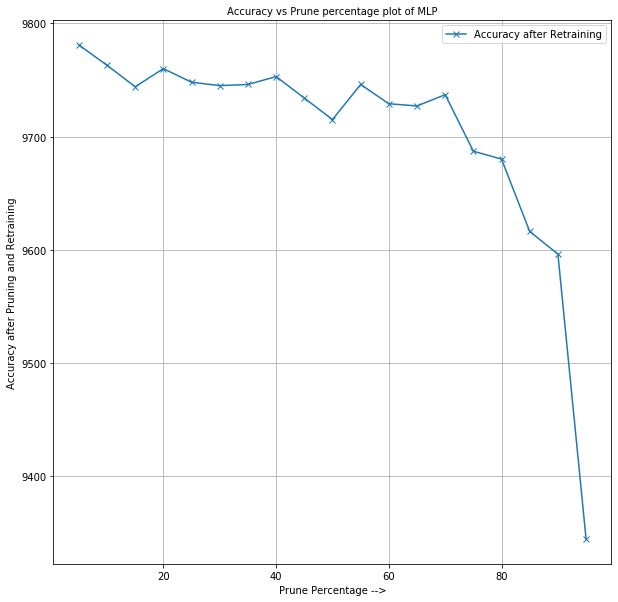

In [32]:
plt.figure(figsize=(10,10))
test_acc_arr = test_acc_arr*100
plt.plot(np.array(prune_percentage),test_acc_arr,marker='x',label='Accuracy after Retraining')
plt.title("Accuracy vs Prune percentage plot of MLP",fontsize=10) 
plt.xlabel('Prune Percentage -->')
plt.ylabel('Accuracy after Pruning and Retraining')    
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()